<a href="https://colab.research.google.com/github/25i6/semantic-segmentation/blob/main/notebooks/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!git clone https://github.com/sithu31296/semantic-segmentation
%cd semantic-segmentation
%pip install -e .

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 801, done.
remote: Counting objects: 100% (798/798), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 801 (delta 485), reused 756 (delta 474), pack-reused 3 (from 1)
Receiving objects: 100% (801/801), 54.99 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (485/485), done.
/content/semantic-segmentation
Obtaining file:///content/semantic-segmentation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=7fa7057d328cd8f295d17a641f95c2d6b17579fbfce256691b78d88675017c90
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Cre

In [2]:
import torch
from torchvision import io
from torchvision import transforms as T
from PIL import Image

def show_image(image):
    if image.shape[2] != 3: image = image.permute(1, 2, 0)
    image = Image.fromarray(image.numpy())
    return image

## Show Available Pretrained Models

In [3]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


## Load a Pretrained Model

Download a pretrained model's weights from the result table (ADE20K, CityScapes, ...) and put it in `checkpoints/pretrained/model_name/`.

In [4]:
%pip install -U gdown

In [5]:
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT
From (redirected): https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT&confirm=t&uuid=76668ed8-a009-4105-a9d0-49b45a8e718f
To: /content/semantic-segmentation/checkpoints/pretrained/segformer/segformer.b3.ade.pth
100%|██████████| 190M/190M [00:01<00:00, 113MB/s]


'./checkpoints/pretrained/segformer/segformer.b3.ade.pth'

In [6]:
from semseg.models import *

model = eval('SegFormer')(
    backbone='MiT-B3',
    num_classes=150
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

print('Loaded Model')

<ipython-input-6-288208e8de82>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map

Loaded Model


## Simple Image Inference

### Load Image

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


torch.Size([3, 512, 512])


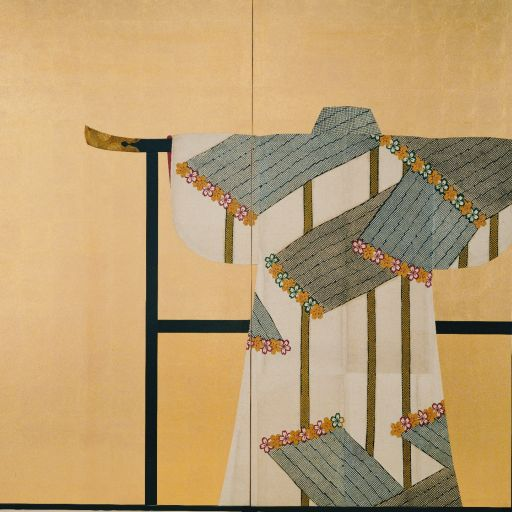

In [24]:
image_path = '/content/drive/MyDrive/2025autum/02_Special_Laboratory/02_kosode/junk_box/14-D-201350-100-0003.jpg'#最後がjpgとかじゃなくて日本語だと一個下のブロックでエラー
image = io.read_image(image_path)
print(image.shape)
show_image(image)

### Preprocess

In [25]:
# resize
image = T.CenterCrop((512, 512))(image)
# scale to [0.0, 1.0]
image = image.float() / 255
# normalize
image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
# add batch size
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 512, 512])

### Model Forward

In [26]:
with torch.inference_mode():
    seg = model(image)
seg.shape

torch.Size([1, 150, 512, 512])

### Postprocess

In [27]:
seg = seg.softmax(1).argmax(1).to(int)
#
seg_unique = seg.unique()
seg.unique()

tensor([  0,   1,   3,   7,   8,  14,  15,  18,  19,  39,  66,  81,  92, 131])

In [28]:
from semseg.datasets import *

palette = eval('ADE20K').PALETTE

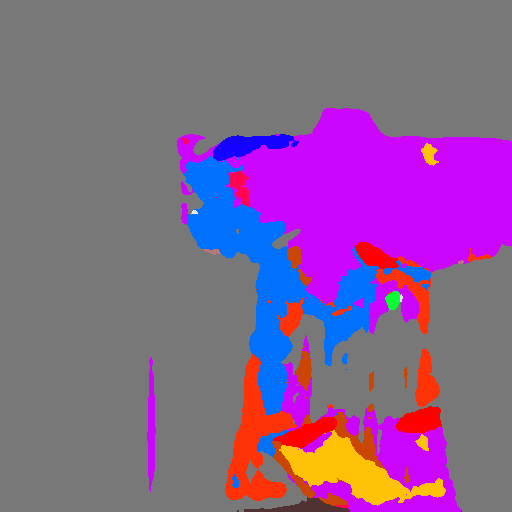

In [29]:
seg_map = palette[seg].squeeze().to(torch.uint8)
show_image(seg_map)

追加

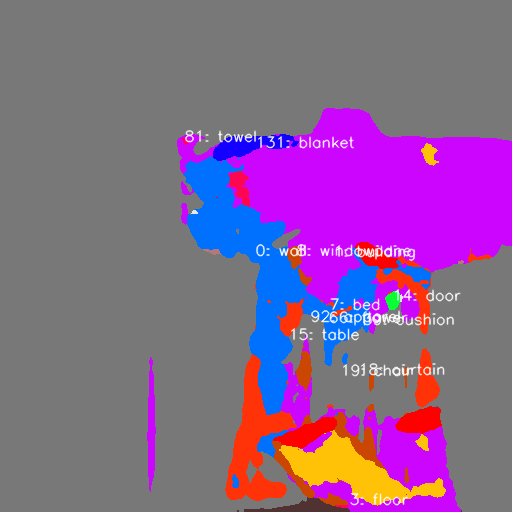

In [31]:
import torch
import numpy as np
import cv2
from semseg.datasets import ADE20K  # 例として ADE20K を利用

# -------------------------
# ① セグメンテーション結果の後処理
# -------------------------
# ※ seg はネットワークの出力テンソルとします（例: [B, num_classes, H, W]）
#    ここではバッチサイズ1を前提としています。

# # 各ピクセルのクラスを softmax と argmax で求める
# seg = seg.softmax(1).argmax(1).to(torch.int)  # seg の shape は [1, H, W] になることを想定
# seg_unique = seg.unique()  # 画像内に現れるユニークなクラス番号

# -------------------------
# ② カラーパレットを用いたセグメンテーションマップの生成
# -------------------------
# ADE20K のパレット（色リスト）を取得
palette = ADE20K.PALETTE
# クラス名が定義されている場合（ADE20K.CLASSES など）：
classes = ADE20K.CLASSES if hasattr(ADE20K, 'CLASSES') else None

# seg の各画素に対してパレットの色を適用
# ※ palette[seg] の結果はテンソルで、形状は [1, H, W, 3] となることを想定
seg_map = palette[seg].squeeze().to(torch.uint8)  # shape: [H, W, 3]

# -------------------------
# ③ NumPy 配列に変換して各クラス領域に注釈を描画
# -------------------------
# テンソルを NumPy 配列へ変換（以降 OpenCV の描画処理のため）
seg_np = seg.squeeze().cpu().numpy()      # [H, W]（クラス番号）
seg_map_np = seg_map.cpu().numpy()          # [H, W, 3]（カラー画像）

# 画像のコピーを用意（注釈描画用）
annotated_img = seg_map_np.copy()

# ユニークな各クラス番号について処理
for cls in seg_unique.tolist():
    # 該当クラスのマスク作成
    mask = (seg_np == cls)
    if np.sum(mask) == 0:
        continue

    # マスク上のピクセル座標を取得
    coords = np.argwhere(mask)
    # 領域の左上と右下の座標（バウンディングボックス）を算出
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)
    # バウンディングボックスの中心点を求める
    center_y, center_x = int((y0 + y1) / 2), int((x0 + x1) / 2)

    # クラス番号と、可能ならタグ名（クラス名）をテキストに
    label_text = f"{cls}"
    if classes is not None and cls < len(classes):
        label_text += f": {classes[cls]}"

    # OpenCV の putText 関数でテキストを描画
    # 第4引数はフォント、第5引数はフォントサイズ、(255,255,255) はテキスト色（白）
    cv2.putText(annotated_img, label_text, (center_x, center_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255),
                thickness=1, lineType=cv2.LINE_AA)

# -------------------------
# ④ 結果の表示
# -------------------------
# ここでは show_image 関数を使って画像を表示します（実装は各自）
show_image(torch.from_numpy(annotated_img))


## Show Available Backbones

In [ ]:
from semseg import show_backbones

show_backbones()

## Show Available Heads

In [ ]:
from semseg import show_heads

show_heads()

## Show Available Datasets

In [ ]:
from semseg import show_datasets

show_datasets()

## Construct a Custom Model

### Choose a Backbone

In [ ]:
from semseg.models.backbones import ResNet

backbone = ResNet('18')

In [ ]:
# init random input batch
x = torch.randn(2, 3, 224, 224)

In [ ]:
# get features from the backbone
features = backbone(x)
for out in features:
    print(out.shape)

### Choose a Head

In [ ]:
from semseg.models.heads import UPerHead

head = UPerHead(backbone.channels, 128, num_classes=10)

In [ ]:
seg = head(features)
seg.shape

In [ ]:
from torch.nn import functional as F
# upsample the output
seg = F.interpolate(seg, size=x.shape[-2:], mode='bilinear', align_corners=False)
seg.shape

Check `semseg/models/custom_cnn.py` and `semseg/models/custom_vit.py` for a complete construction for custom model.